# Create a recommendation system for people to watch movies.


The context of the problem is a table of movies and whether or not people like the movie. The recommendation system works by categorizing a movie into traits (trait) and people into whether or not they like certain traits (preference). Given ratings of a certain user, you can use inference to work backwards and set their preferences. 
Each trait needs to be rooted by a movie; it defines a trait axis. Given data of all users you can determine where movies fall relative to the rooted movie using inference and working backwards again.

# Theoretical Example

The trait axis has been defined on A.

Can you infer information about the questionmarks?

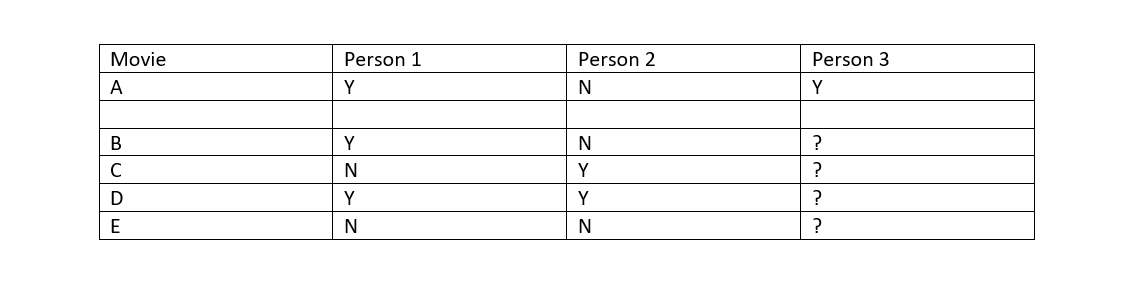

In [3]:
from IPython.display import Image, display
display(Image(filename="sampletable.png"))

# Simple Factor Graph

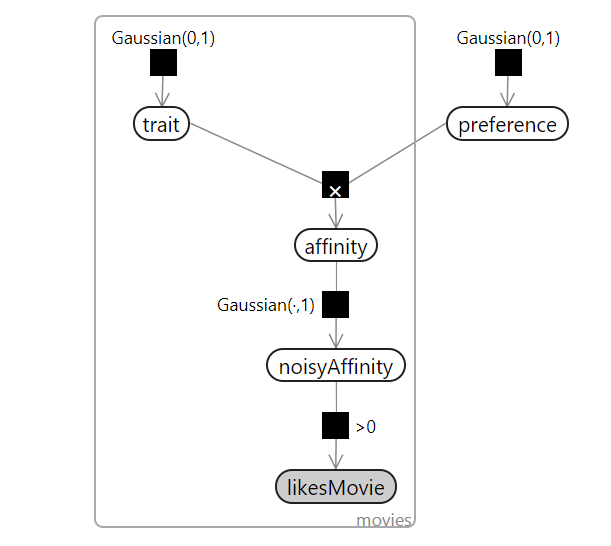

In [4]:
display(Image(filename="factorgraph1.png"))

Given trait mean and standard deviation for each movie, and the preference trait for the person this model can compute if the person likes the movie.

From the graph we can write out the full joint as

$$ p(l, t, p, \tilde{A}; \mu_t,\sigma_t,\mu_p,\sigma_p) = p(p)*\prod_{i=1}^N p(t_i) * p(l_i \mid \tilde{A}_i) p(\tilde{A}_i \mid t_i,p) $$

where $l$ is the likesMovie, $t$ is the trait, $p$ is the preferance, $\tilde{A}$ is the noisyAffinity

# Our Implementation

In [5]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import torch
import numpy as np
import pandas as pd

# fAKE  x data


y_temp = np.array([1 if(i%2==0) else 0 for i in range(0, 10)])

print(y_temp)
y = torch.Tensor(y_temp.astype(np.float32))


#y = torch.Tensor(dataXy[:,1].astype(np.float32))

[1 0 1 0 1 0 1 0 1 0]


In [6]:
def model_sigmoid_obs(y,debug=False,theta=[0.0,1.0,0.0,1.0]):
    '''param x: batch_size x 1 
       param y: batch_size x 1'''
        
    # these are parameters for the model (and will be our variational parameters for the guide)
    mean_pref = torch.tensor(theta[0])
    std_pref = torch.sqrt(torch.tensor(theta[1]))
    draw_pref = pyro.sample("draw_pref",dist.Normal(mean_pref,std_pref))

    mean_trait = torch.tensor(theta[2])
    std_trait = torch.tensor(theta[3])
    
    for i in pyro.plate("movies", len(y)):
        if i == 0:
            draw_trait = pyro.sample("draw_trait_{}".format(i), dist.Normal(torch.tensor(5.),std_trait), obs = torch.tensor(5.))     
        else:
            draw_trait = pyro.sample("draw_trait_{}".format(i), dist.Normal(mean_trait,std_trait))
        noisy_affinity = pyro.sample('noisey_affinity_{}'.format(i), dist.Normal(draw_trait*draw_pref,torch.tensor(1.0)))
        likes_movie = pyro.sample('likes_movie_{}'.format(i),dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[i])


In [7]:
def guide(y):
    '''param x: batch_size x 1 
       param y: batch_size x 1'''
    
    # these are parameters for the model
    mean_pref = pyro.param("mean_pref",torch.tensor(0.0))
    std_pref = pyro.param("std_pref",torch.tensor(10.0),constraint=constraints.positive)
    draw_pref = pyro.sample("draw_pref",dist.Normal(mean_pref,std_pref))
    
    
    
    
    for i in pyro.plate("movies", len(y)):

        if i == 0:
            pass
#             mean_trait = pyro.param("mean_trait_{}".format(i), torch.tensor(5.0))
        else:
            mean_trait = pyro.param("mean_trait_{}".format(i), torch.tensor(0.0))
            std_trait = pyro.param("std_trait_{}".format(i), torch.tensor(10.0)) 

        if i != 0:
        #sig_t,sig_w = (1e-7,1e-7)
            draw_trait = pyro.sample("draw_trait_{}".format(i) ,dist.Normal(mean_trait,std_trait))

   

In [8]:
import matplotlib.pyplot as plt

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_sigmoid_obs,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.01, "momentum":0.001}),
                     loss=pyro.infer.Trace_ELBO())

mean_preferences = []
losses =[]

trait_mean0 = []
trait_mean1 = []
trait_mean2 = []
trait_mean3 = []


num_steps = 500
for i in range(num_steps):
    losses.append(svi.step(y))
    mean_preferences.append(pyro.param("mean_pref").item())
    
#     trait_mean0.append(pyro.param("mean_trait_0").item())
    trait_mean1.append(pyro.param("mean_trait_1").item())
    trait_mean2.append(pyro.param("mean_trait_2").item())
    trait_mean3.append(pyro.param("mean_trait_3").item())
    
    if(i%10 == 0):
        print(".", end='')
        
print("")       
print(y)

print("mean_preferences")
print(mean_preferences[-5:])

# print("trait_mean0")
# print(trait_mean0[-5:])

print("trait_mean1")
print(trait_mean1[-5:])

print("trait_mean2")
print(trait_mean2[-5:])

print("trait_mean3")
print(trait_mean3[-5:])


..................................................
tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])
mean_preferences
[0.6923158764839172, 0.6991684436798096, 0.6924087405204773, 0.6703231334686279, 0.6570576429367065]
trait_mean1
[-0.2965957224369049, -0.29024502635002136, -0.31104788184165955, -0.32420337200164795, -0.31782376766204834]
trait_mean2
[0.2029213011264801, 0.2068382352590561, 0.20729002356529236, 0.1939036250114441, 0.19077672064304352]
trait_mean3
[-0.25719282031059265, -0.2682045102119446, -0.2652800679206848, -0.281058132648468, -0.28906404972076416]


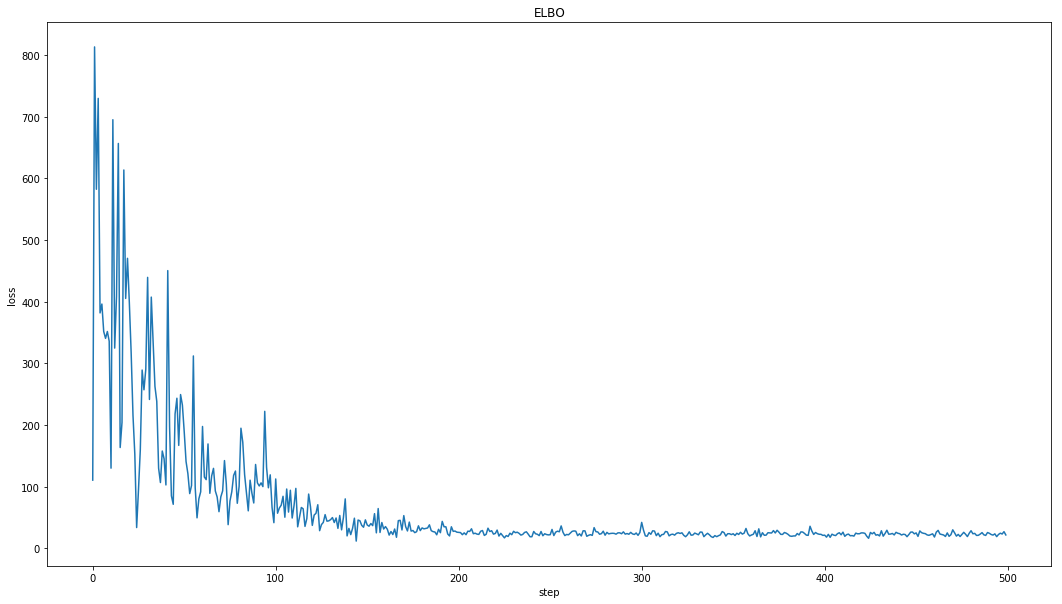

In [9]:
plt.figure(figsize=(18,10))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
plt.show()

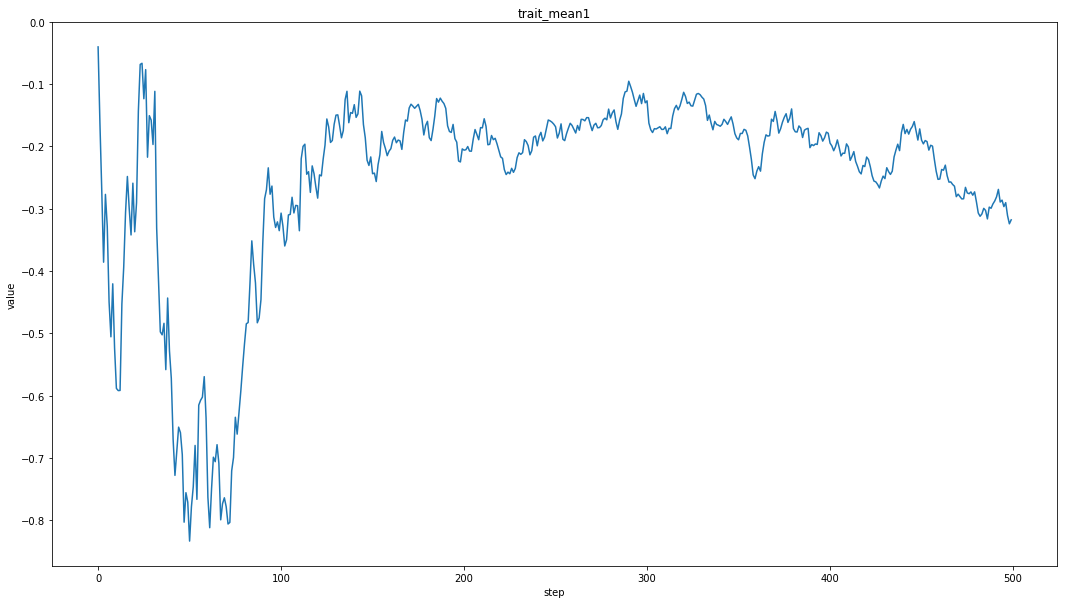

In [10]:
plt.figure(figsize=(18,10))
plt.plot(trait_mean1)
plt.title("trait_mean1")
plt.xlabel("step")
plt.ylabel("value");
plt.show()

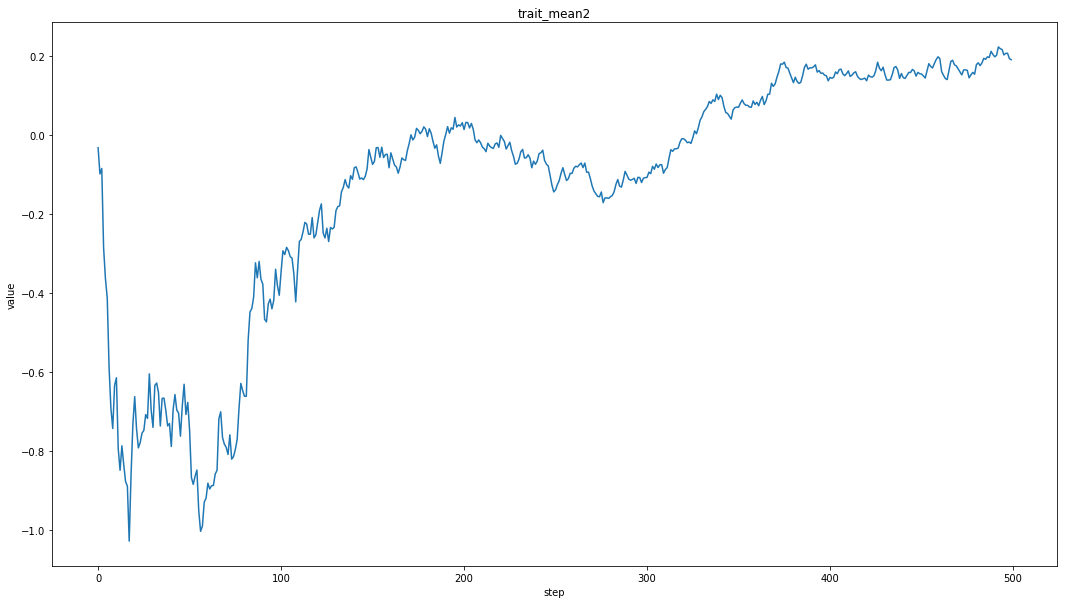

In [11]:
plt.figure(figsize=(18,10))
plt.plot(trait_mean2)
plt.title("trait_mean2")
plt.xlabel("step")
plt.ylabel("value");
plt.show()

This model correctly predicts whether or not someone likes a movie on data we trained on. This is not particularly impressive, but it took some effort figuring out how to set up the model, guide, what to initialize variables at, implying inference, etc.

We cannot guess if a person will like a movie he/she hasn't seen yet since the trait variable for a movie is currently trained on only one person.

The next step in the chapter was adding multiple traits to each movie.

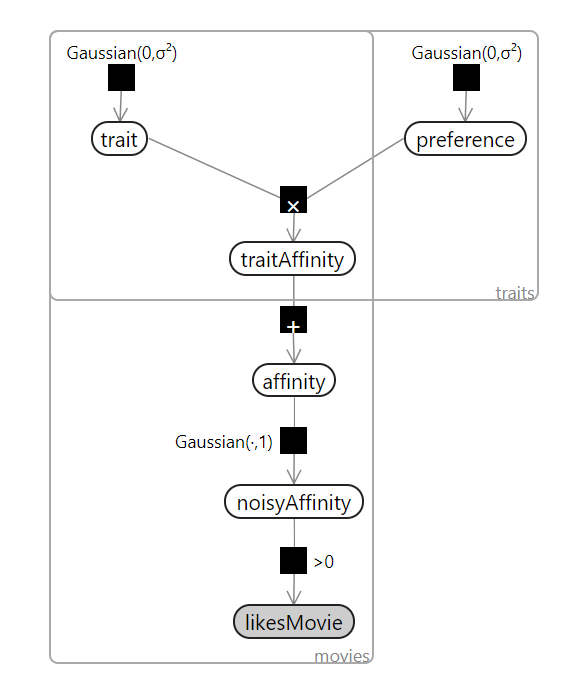

In [12]:
display(Image(filename="factorgraph2.png"))

In [13]:
def model_sigmoid_obs(y,num_traits, debug=False,theta=[0.0,1.0,0.0,1.0]):  
    preferences_list = []
    mean_pref = torch.tensor(theta[0])
    std_pref = torch.sqrt(torch.tensor(theta[1]))
        
    for i in pyro.plate("traits_model", num_traits):
        draw_pref = pyro.sample("draw_pref_{}".format(i),dist.Normal(mean_pref,std_pref))
        preferences_list.append(draw_pref)
        
    mean_trait = torch.tensor(theta[2])
    std_trait = torch.tensor(theta[3])
    
    for i in pyro.plate("movies", len(y)):
        
        affinity = 0
        for j in range(0, num_traits):
            
            if i == 0 and j == 0:
                draw_trait = pyro.sample("draw_trait_{}_{}".format(i,j), dist.Normal(torch.tensor(5.),std_trait), obs = torch.tensor(5.))     
            elif i == 0 and j == 1:
                draw_trait = pyro.sample("draw_trait_{}_{}".format(i,j), dist.Normal(torch.tensor(-5.),std_trait), obs = torch.tensor(-5.))                     
            else:
                draw_trait = pyro.sample("draw_trait_{}_{}".format(i,j), dist.Normal(mean_trait,std_trait))
            

            affinity = affinity + draw_trait*preferences_list[j]
            
        noisy_affinity = pyro.sample('noisey_affinity_{}'.format(i), dist.Normal(affinity, torch.tensor(5.0)))
        likes_movie = pyro.sample('likes_movie_{}'.format(i),dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[i])


In [14]:
def guide(y, num_traits):
    '''param x: batch_size x 1 
       param y: batch_size x 1'''
    
    # these are parameters for the model
    #preferences_list = []
    for i in pyro.plate("traits_model", num_traits):
        mean_pref = pyro.param("mean_pref_{}".format(i), torch.tensor(0.0))
        std_pref = pyro.param("std_pref_{}".format(i), torch.tensor(10.0),constraint=constraints.positive)
        draw_pref = pyro.sample("draw_pref_{}".format(i), dist.Normal(mean_pref,std_pref))
        #preferences_list.append(draw_pref)

    
    
    
    for i in pyro.plate("movies", len(y)):
        for j in range(0,num_traits):

            mean_trait = pyro.param("mean_trait_{}_{}".format(i,j), torch.tensor(0.0))
            std_trait = pyro.param("std_trait_{}_{}".format(i,j), torch.tensor(10.0)) 

            if i != 0:
                draw_trait = pyro.sample("draw_trait_{}_{}".format(i,j) ,dist.Normal(mean_trait,std_trait))

                
                

   

In [15]:
import matplotlib.pyplot as plt

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_sigmoid_obs,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.005, "momentum":0.001}),
                     loss=pyro.infer.Trace_ELBO())

mean_preferences = []
mean2_preferences = []

losses =[]

trait_mean0 = []
trait_mean1 = []
trait_mean2 = []
trait_mean3 = []
trait_mean4 = []
trait_mean5 = []

trait2_mean0 = []
trait2_mean1 = []
trait2_mean2 = []
trait2_mean3 = []
trait2_mean4 = []
trait2_mean5 = []

num_traits = 2

num_steps = 500
for i in range(num_steps):
    losses.append(svi.step(y, num_traits))
    mean_preferences.append(pyro.param("mean_pref_0").item())
    mean2_preferences.append(pyro.param("mean_pref_1").item())

    
    #trait_mean0.append(pyro.param("mean_trait_0").item())
    trait_mean1.append(pyro.param("mean_trait_1_0").item())
    trait_mean2.append(pyro.param("mean_trait_2_0").item())
    trait_mean3.append(pyro.param("mean_trait_3_0").item())
    trait_mean4.append(pyro.param("mean_trait_4_0").item())
    trait_mean5.append(pyro.param("mean_trait_5_0").item())
    
    trait2_mean1.append(pyro.param("mean_trait_1_1").item())
    trait2_mean2.append(pyro.param("mean_trait_2_1").item())
    trait2_mean3.append(pyro.param("mean_trait_3_1").item())
    trait2_mean4.append(pyro.param("mean_trait_4_1").item())
    trait2_mean5.append(pyro.param("mean_trait_5_1").item())
    
    if(i%10 == 0):
        print(".", end='')

print("")
print(y)
print("y")
howmanytoprint = -5
print("mean_preferences")
print(mean_preferences[howmanytoprint:])
print("mean2_preferences")
print(mean2_preferences[howmanytoprint:])

print("trait_mean0")
print(trait_mean0[howmanytoprint:])

print("trait_mean1")
print(trait_mean1[howmanytoprint:])

print("trait_mean2")
print(trait_mean2[howmanytoprint:])

print("trait_mean3")
print(trait_mean3[howmanytoprint:])

print("trait_mean4")
print(trait_mean4[howmanytoprint:])

print("trait_mean5")
print(trait_mean5[howmanytoprint:])

print("")

print("trait2_mean0")
print(trait2_mean0[howmanytoprint:])

print("trait2_mean1")
print(trait2_mean1[howmanytoprint:])

print("trait2_mean2")
print(trait2_mean2[howmanytoprint:])

print("trait2_mean3")
print(trait2_mean3[howmanytoprint:])

print("trait2_mean4")
print(trait2_mean4[howmanytoprint:])

print("trait2_mean5")
print(trait2_mean5[howmanytoprint:])


..................................................
tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])
y
mean_preferences
[0.5812809467315674, 0.5541315674781799, 0.5854155421257019, 0.5969055891036987, 0.5858191847801208]
mean2_preferences
[-0.5451012253761292, -0.5433981418609619, -0.5713930130004883, -0.5716848969459534, -0.5561476349830627]
trait_mean0
[]
trait_mean1
[-0.24484509229660034, -0.26316601037979126, -0.2670978009700775, -0.2649093270301819, -0.2721787989139557]
trait_mean2
[0.25301462411880493, 0.2695242762565613, 0.2675520181655884, 0.27049997448921204, 0.2684119641780853]
trait_mean3
[0.014687939547002316, 0.011820252053439617, 0.008054850623011589, 0.005971729755401611, -0.0006810254417359829]
trait_mean4
[0.040751464664936066, 0.04111219197511673, 0.05047295615077019, 0.052875928580760956, 0.06308315694332123]
trait_mean5
[-0.32300427556037903, -0.31974324584007263, -0.313900351524353, -0.3105360269546509, -0.30497127771377563]

trait2_mean0
[]
trait2_mean1
[0.05385243

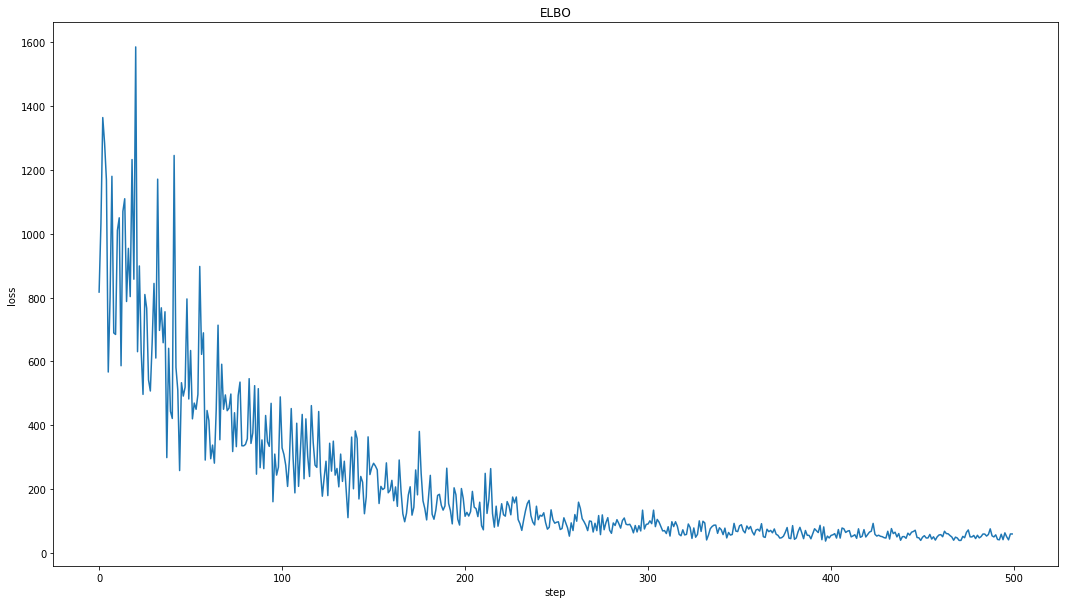

In [16]:
plt.figure(figsize=(18,10))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
plt.show()

Ok so now each movie can have multiple traits. But the problem from before remains. We are currently testing out program on training data. To be able to infer if someone likes a movie they have not seen yet we need to add multiple people to the model. Multiple people will allow us to infer the trait variable of a movie without everyone having to rate it.

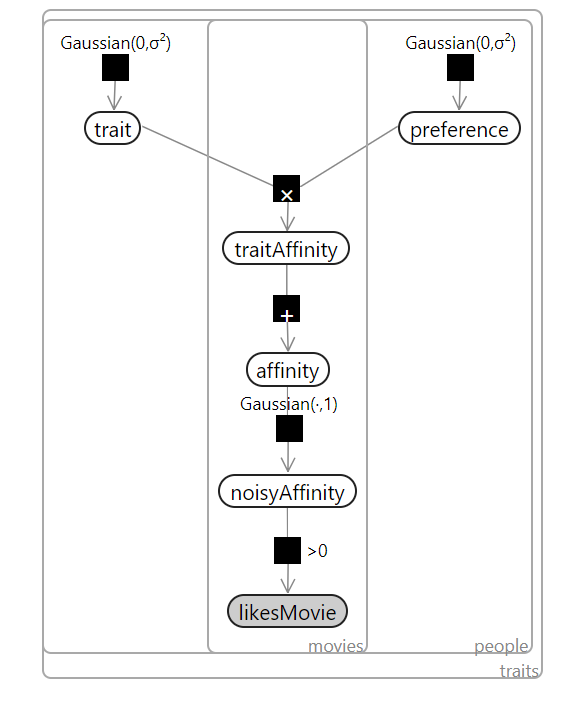

In [17]:
display(Image(filename="factorgraph3.png"))

In [18]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import torch
import numpy as np

# fAKE  x data


#y_temp = np.array([1 if(j%2==0) else 0 for i in range(0, 10) for j in range(0,10)])
y_temp = np.zeros(shape=(2,10))
for i in range(0, len(y_temp)):
    for j in range(0, len(y_temp[i])):
        if(i == 0):
            if(j%2 == 0):
                y_temp[i,j] = 1
            else:
                y_temp[i,j] = 0
        else:
            if(j%2 == 0):
                y_temp[i,j] = 0
            else:
                y_temp[i,j] = 1            

#         y_temp[i,j] = np.random.randint(2)
        
#         else:
#             y_temp[i,j] = 0.0

print(y_temp)
#y_temp[0][1] = -1
y = torch.Tensor(y_temp.astype(np.float32))



#y = torch.Tensor(dataXy[:,1].astype(np.float32))

[[1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]]


In [19]:
def model_sigmoid_obs(y, num_movies, num_traits, num_people, debug=False,theta=[0.0,1.0,0.0,1.0]):
    '''param x: batch_size x 1 
       param y: batch_size x 1'''
        
    # these are parameters for the model (and will be our variational parameters for the guide)
    preferences_list = []
    mean_pref = torch.tensor(theta[0])
    std_pref = torch.sqrt(torch.tensor(theta[1]))
    
    for k in pyro.plate("people_plate", num_people):
        person = []
        #for i in pyro.plate("traits_model", num_traits):
        for i in range(0, num_traits):
            draw_pref = pyro.sample("draw_pref_person_{}trait_{}".format(k,i),dist.Normal(mean_pref,std_pref))
            person.append(draw_pref)
        preferences_list.append(person)
        
    mean_trait = torch.tensor(theta[2])
    std_trait = torch.tensor(theta[3])
    
    draw_trait_list = []
            
    #for i in pyro.plate("movies", num_movies):
    #for i in range(0, len(y[k])):
    for i in range(0, num_movies):
        #print(i)
        movie_list = []
        for j in range(0, num_traits):

            if i == 0 and j == 0:
                draw_trait = pyro.sample("draw_trait_movies_{}trait_{}".format(i,j), dist.Normal(torch.tensor(5.),std_trait), obs = torch.tensor(5.))     
            elif i == 0 and j == 1:
                draw_trait = pyro.sample("draw_trait_movies_{}trait_{}".format(i,j), dist.Normal(torch.tensor(-5.),std_trait), obs = torch.tensor(-5.))                     
            else:
                draw_trait = pyro.sample("draw_trait_movies_{}trait_{}".format(i,j), dist.Normal(mean_trait,std_trait))
            movie_list.append(draw_trait)
        draw_trait_list.append(movie_list)
        
    #print(draw_trait_list)
    #print(num_movies, num_traits, num_people)

    #Compute likes movie for each person and movie
    #for each person
    for k in pyro.plate("people_plate2", num_people):
        #for each movie 
        for i in range(0, num_movies):
            affinity = 0
            #accumulate the traits for one movie
            for j in range(0, num_traits):
                affinity = affinity + draw_trait_list[i][j]*preferences_list[k][j]

            noisy_affinity = pyro.sample('noisey_affinity_person_{}_movie_{}trait_{}'.format(k, i, j), dist.Normal(affinity, torch.tensor(1.0)))
            if(y[k][i] == -1):
                pass
            else:
                likes_movie = pyro.sample('likes_movie_person_{}_movie_{}trait_{}'.format(k, i, j),dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[k][i])


In [20]:
def guide(y, num_movies, num_traits, num_people):
    '''param x: batch_size x 1 
       param y: batch_size x 1'''
    
    # these are parameters for the model
    #preferences_list = []
    for k in pyro.plate("people_plate", num_people):
        #person = []
        #for i in pyro.plate("traits_model", num_traits):
        for i in range(0, num_traits):
            mean_pref = pyro.param("mean_pref_person_{}trait_{}".format(k,i), torch.tensor(0.0))
            std_pref = pyro.param("std_pref_person_{}trait_{}".format(k,i), torch.tensor(10.0),constraint=constraints.positive)
            draw_pref = pyro.sample("draw_pref_person_{}trait_{}".format(k,i), dist.Normal(mean_pref,std_pref))
            #mean_pref_person_{}trait_{}
            #draw_pref_person_{}trait_{}
            
            #preferences_list.append(draw_pref)


    
    
    for i in pyro.plate("movies", num_movies):
        #affinity = 0
        for j in range(0,num_traits):

#             if i == 0:
#                 pass
#     #             mean_trait = pyro.param("mean_trait_{}".format(i), torch.tensor(5.0))
#             else:

            mean_trait = pyro.param("mean_trait_{}_{}".format(i,j), torch.tensor(0.0))
            std_trait = pyro.param("std_trait_{}_{}".format(i,j), torch.tensor(10.0)) 

            if i != 0:
            #sig_t,sig_w = (1e-7,1e-7)
                draw_trait = pyro.sample("draw_trait_movies_{}trait_{}".format(i,j) ,dist.Normal(mean_trait,std_trait))
                #affinity = affinity + draw_trait*preferences_list[j]
        #noisy_affinity = pyro.sample('noisey_affinity_{}'.format(i), dist.Normal(affinity, torch.tensor(0.1)))


                
                

   

In [21]:
import matplotlib.pyplot as plt

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_sigmoid_obs,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.005, "momentum":0.001}),
                     loss=pyro.infer.Trace_ELBO())

mean_preferences_person0 = []
mean2_preferences_person0 = []

mean_preferences_person1 = []
mean2_preferences_person1 = []


losses =[]

trait_mean0 = []
trait_mean1 = []
trait_mean2 = []
trait_mean3 = []
trait_mean4 = []
trait_mean5 = []

trait2_mean0 = []
trait2_mean1 = []
trait2_mean2 = []
trait2_mean3 = []
trait2_mean4 = []
trait2_mean5 = []

trait1_std_movie1 = []

num_traits = 2
num_people = 2
num_movies = 10

num_steps = 500
for i in range(num_steps):
    #losses.append(svi.step(y, num_movies, num_traits, num_people))
    losses.append(svi.step(y, 10, 2, 2))
    mean_preferences_person0.append(pyro.param("mean_pref_person_0trait_0").item())
    mean2_preferences_person0.append(pyro.param("mean_pref_person_0trait_1").item())
    
    mean_preferences_person1.append(pyro.param("mean_pref_person_1trait_0").item())
    mean2_preferences_person1.append(pyro.param("mean_pref_person_1trait_1").item())

    
    #trait_mean0.append(pyro.param("mean_trait_0").item())
    trait_mean1.append(pyro.param("mean_trait_1_0").item())
    trait_mean2.append(pyro.param("mean_trait_2_0").item())
    trait_mean3.append(pyro.param("mean_trait_3_0").item())
    trait_mean4.append(pyro.param("mean_trait_4_0").item())
    trait_mean5.append(pyro.param("mean_trait_5_0").item())
    
    trait2_mean1.append(pyro.param("mean_trait_1_1").item())
    trait2_mean2.append(pyro.param("mean_trait_2_1").item())
    trait2_mean3.append(pyro.param("mean_trait_3_1").item())
    trait2_mean4.append(pyro.param("mean_trait_4_1").item())
    trait2_mean5.append(pyro.param("mean_trait_5_1").item())
    trait1_std_movie1.append(pyro.param("std_trait_1_0").item())
    
    if(i%10 == 0):
        print(".", end='')
        
print("")
print(y)

howmanytoprint = -5
print("person 1")
print("first trait mean_preferences")
print(mean_preferences_person0[howmanytoprint:])
print("second trait mean_preferences")
print(mean2_preferences_person0[howmanytoprint:])

print("person 2")
print("first trait mean_preferences")
print(mean_preferences_person1[howmanytoprint:])
print("second trait mean_preferences")
print(mean2_preferences_person1[howmanytoprint:])




print("first trait per movie")
print("trait_mean0")
print(trait_mean0[howmanytoprint:])

print("trait_mean1")
print(trait_mean1[howmanytoprint:])

print("trait_mean2")
print(trait_mean2[howmanytoprint:])

print("trait_mean3")
print(trait_mean3[howmanytoprint:])

print("trait_mean4")
print(trait_mean4[howmanytoprint:])

print("trait_mean5")
print(trait_mean5[howmanytoprint:])


print("second trait per movie")

print("trait2_mean0")
print(trait2_mean0[howmanytoprint:])

print("trait2_mean1")
print(trait2_mean1[howmanytoprint:])

print("trait2_mean2")
print(trait2_mean2[howmanytoprint:])

print("trait2_mean3")
print(trait2_mean3[howmanytoprint:])

print("trait2_mean4")
print(trait2_mean4[howmanytoprint:])

print("trait2_mean5")
print(trait2_mean5[howmanytoprint:])




..................................................
tensor([[1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]])
person 1
first trait mean_preferences
[0.3133351504802704, 0.2988673448562622, 0.30886757373809814, 0.30938026309013367, 0.3065764307975769]
second trait mean_preferences
[-0.34649938344955444, -0.3284730017185211, -0.3203415870666504, -0.32194095849990845, -0.34463387727737427]
person 2
first trait mean_preferences
[-0.3890517055988312, -0.38457807898521423, -0.3899945914745331, -0.3964065611362457, -0.39318257570266724]
second trait mean_preferences
[0.43831542134284973, 0.4140748977661133, 0.40298545360565186, 0.40961575508117676, 0.40927037596702576]
first trait per movie
trait_mean0
[]
trait_mean1
[-0.26776376366615295, -0.2716134488582611, -0.27219805121421814, -0.27073177695274353, -0.2798011302947998]
trait_mean2
[0.12623509764671326, 0.13028503954410553, 0.12179359793663025, 0.12522193789482117, 0.12705397605895996]
trait_mean3

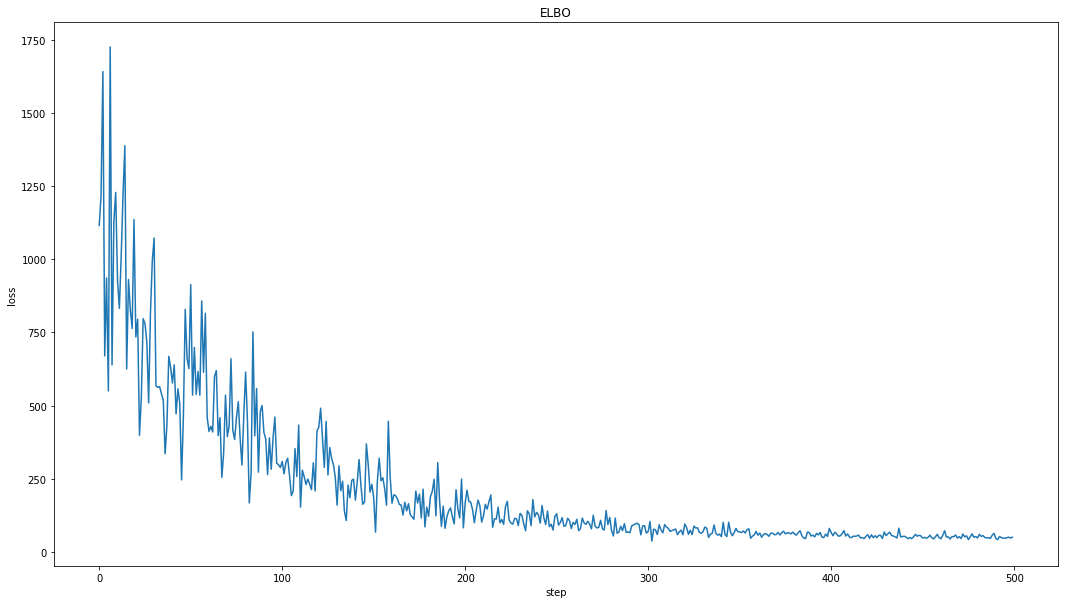

In [22]:
plt.figure(figsize=(18,10))
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
plt.show()

In [23]:
def testing(y):
    
    num_correct = 0
    total = 0
    
    mean_pref =[]
    mean_trait = []
    std_pref = []
    std_trait = []
    
    for name, value in pyro.get_param_store().items():
        if("mean_pref" in name):
            mean_pref.append(value)
        if("mean_trait" in name):
            mean_trait.append(value)
        if("std_pref" in name):
            std_pref.append(value)
        if("std_trait" in name):
            std_trait.append(value)
            
    #print(len(mean_pref))
    #print(len(mean_trait))
    
    for k in range(0, len(y)):
        
        for i in range(1, num_movies):
            
            sum_traits = 0
            for j in range(0, num_traits):

                #pref = np.random.normal(mean_pref[k*2+j].data, std_pref[k*2+j].data)
                #trait = np.random.normal(mean_trait[i*2+j].data, std_trait[i*2+j].data)
                pref = np.random.normal(mean_pref[k*2+j].data, 0.001)
                trait = np.random.normal(mean_trait[i*2+j].data, 0.001)
                  
                
                #print(std_pref[k*2+j].data)
                #print(std_trait[i*2+j].data)
                
                sum_traits = sum_traits + pref*trait
            
            #sum_traits = np.random.normal(sum_traits, .30)
            ans = -1
            if(sum_traits > 0):
                ans = 1
            else:
                ans = 0
            total+=1
            if(y[k][i] == ans):
                num_correct+=1
    #adjust for first 2 movies   
    set_traits = 2
    #num_correct = num_correct + (set_traits*num_people)
    print("num correct")
    print(num_correct)
    print("total")
    print(total)
    print("ratio")
    print((1.0*num_correct)/(1.0*total))
    
    #print(std_pref)
    #print(std_trait)
                
                
                
    
    #np.random.normal(pyro.param("mean_pref_person_0trait_0").item(),  * pyro.param("mean_trait_1_0").item()
testing(y)    
    

num correct
18
total
18
ratio
1.0


# More complicated Test Data


Now that we have the rudimentary model completed we would like to test it on more complicated examples and tidy it up. Previously we were writing out the parameters defined in the guide explicitly. We figured out how to vectorize the variables into a matrix making the code and analysis simpler.

Then we tested the model with 8 people, 100 movies, and 30 traits. We are still testing the model on training data, but this is a more complicated scenario.


In [24]:
def model_multi_people(y, num_traits):
    num_people, num_movies = y.shape
    mean_pref = torch.tensor(0.)
    std_pref = torch.tensor(1.)
    mean_trait = torch.tensor(0.)
    std_trait = torch.tensor(1.)
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
    
    known_trait = pyro.sample("known_trait", dist.Normal(mean_trait, std_trait), obs = torch.eye(num_traits))
    known_affinity = torch.mm(pref, known_trait.transpose(0,1))
    known_noisy_affinity = pyro.sample('known_noisy_affinity', dist.Normal(known_affinity,torch.tensor(0.2)))
    known_likes_movie = pyro.sample('known_likes_movie',dist.Bernoulli(torch.sigmoid(known_noisy_affinity)), obs=y[:,:num_traits])
    
    affinity = torch.mm(pref, trait.transpose(0,1))
    noisy_affinity = pyro.sample('noisy_affinity', dist.Normal(affinity, torch.tensor(0.2)))
    likes_movie = pyro.sample('likes_movie',dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[:,num_traits:])
    
def guide(y, num_traits):
    num_people, num_movies = y.shape
    
    mean_pref = pyro.param("mean_pref", torch.zeros(num_people, num_traits)+5)
    std_pref = pyro.param("std_pref", torch.ones(num_people, num_traits))
    mean_trait = pyro.param("mean_trait", torch.zeros(num_movies-num_traits,num_traits)+5)
    std_trait = pyro.param("std_trait", torch.ones(num_movies-num_traits,num_traits))
    # each movie and person should have their own distribution, so the following is wrong
#     mean_pref = pyro.param("mean_pref", torch.tensor(10.))
#     std_pref = pyro.param("std_pref", torch.tensor(1.))
#     mean_trait = pyro.param("mean_trait", torch.tensor(10.))
#     std_trait = pyro.param("std_trait", torch.tensor(1.))
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))

def check_accuracy(y):
    testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))
    testing_result = torch.sign(testing_values)
    testing_result[testing_result==-1]=0.
#     print('testing_result\n',testing_result)
#     print('truth\n',y[:,num_traits:])
    a,b = testing_result.shape
    return torch.sum(testing_result == y[:,num_traits:]).float()/(a*b)
def check_accuracy_sampling(y):
    pref = pyro.sample("pref",dist.Normal(pyro.param("mean_pref").data, pyro.param("std_pref").data))
    trait = pyro.sample("trait",dist.Normal(pyro.param("mean_trait").data, pyro.param("std_trait").data))
    
    testing_values = torch.mm(pref, trait.data.transpose(0,1))
    testing_result = torch.sign(testing_values)
    testing_result[testing_result==-1]=0.
#     print('testing_result\n',testing_result)
#     print('truth\n',y[:,num_traits:])
    a,b = testing_result.shape
    return torch.sum(testing_result == y[:,num_traits:]).float()/(a*b)


..................................................

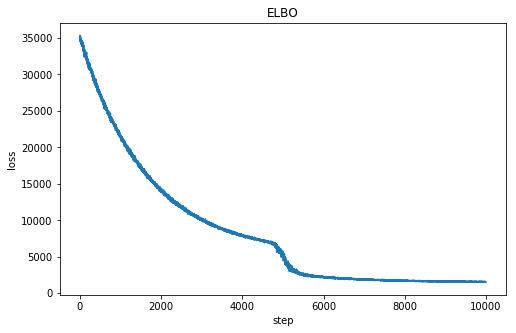

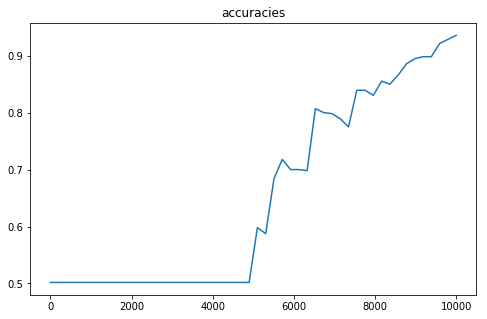

In [25]:
# generate fake data  (num_people, num_movies)
y = torch.randint(2, size = (8,100)).float()
# print('fake data\n',y)

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_multi_people,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.0003, "momentum":0.0002}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
accuracies =[]
num_steps = 10000
num_traits = 30
for i in range(num_steps):
    losses.append(svi.step(y, num_traits))
    if(i%200==0):
        accuracies.append(check_accuracy(y) )
        print(".", end='')
        
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()
plt.figure(figsize=(8,5))    
plt.plot(np.linspace(0,num_steps,len(accuracies)),accuracies)
plt.title("accuracies")
plt.show()

In [26]:
check_accuracy(y)

tensor(0.9500)

In [27]:
check_accuracy_sampling(y)

tensor(0.6232)

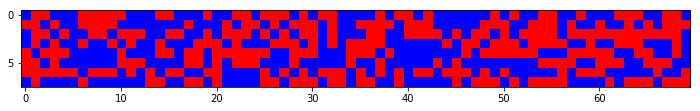

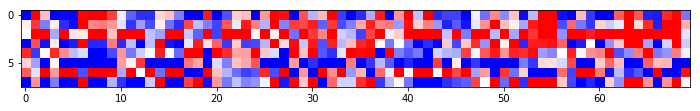

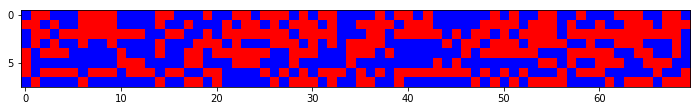

In [28]:
plt.figure(figsize=(12,3)) 
y[y==0]=-1
plt.imshow(y[:,num_traits:], cmap='bwr', vmin=-1., vmax=1.)
plt.show()

testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))
plt.figure(figsize=(12,3)) 
plt.imshow(testing_values, cmap='bwr', vmin=-1., vmax=1.)
plt.show()

testing_result = torch.sign(testing_values)
plt.figure(figsize=(12,3)) 
plt.imshow(testing_result, cmap='bwr', vmin=-1., vmax=1.)
plt.show()

 The top plot are the true values, the middle plot contains the estimation with variance added, and the last plot is the estimate with no variance. Red means liked movie, blue dislike, white inconclusive.

# Even more complicated data
The real test data we have has lots and lots of missing data. To incorporate the missing data into our framework we randomly replaced half of our data set with -1 while training the model. Pyro contains a mask function which implements this functionality.


In [29]:
def model_with_mask(y, num_traits):
    num_people, num_movies = y.shape
    mean_pref = torch.tensor(0.)
    std_pref = torch.tensor(1.)
    mean_trait = torch.tensor(0.)
    std_trait = torch.tensor(1.)
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
    
    known_trait = pyro.sample("known_trait", dist.Normal(mean_trait, std_trait), obs = torch.eye(num_traits))
    known_affinity = torch.mm(pref, known_trait.transpose(0,1))
    known_noisy_affinity = pyro.sample('known_noisy_affinity', dist.Normal(known_affinity,torch.tensor(0.2)))
    is_observed = (y[:,:num_traits] != -1)
    with pyro.poutine.mask(mask=is_observed):
        known_likes_movie = pyro.sample('known_likes_movie',dist.Bernoulli(torch.sigmoid(known_noisy_affinity)), obs=y[:,:num_traits])
    
    affinity = torch.mm(pref, trait.transpose(0,1))
    noisy_affinity = pyro.sample('noisy_affinity', dist.Normal(affinity, torch.tensor(0.2)))
    
    is_observed = (y[:,num_traits:] != -1)
    with pyro.poutine.mask(mask=is_observed):
        likes_movie = pyro.sample('likes_movie',dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[:,num_traits:])
    
def guide(y, num_traits):
    num_people, num_movies = y.shape
    
    mean_pref = pyro.param("mean_pref", torch.zeros(num_people, num_traits)+2)
    std_pref = pyro.param("std_pref", torch.ones(num_people, num_traits))
    mean_trait = pyro.param("mean_trait", torch.zeros(num_movies-num_traits,num_traits)+2)
    std_trait = pyro.param("std_trait", torch.ones(num_movies-num_traits,num_traits))
    # each movie and person should have their own distribution, so the following is wrong
#     mean_pref = pyro.param("mean_pref", torch.tensor(10.))
#     std_pref = pyro.param("std_pref", torch.tensor(1.))
#     mean_trait = pyro.param("mean_trait", torch.tensor(10.))
#     std_trait = pyro.param("std_trait", torch.tensor(1.))
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))



....................................................................................................

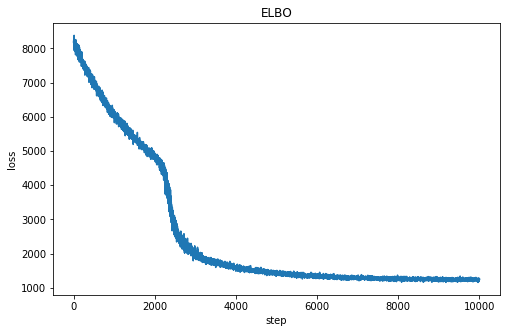

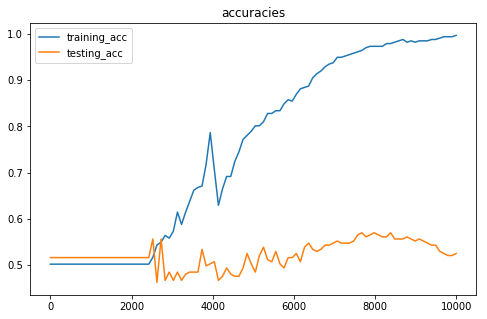

In [30]:
# generate fake data  (num_people, num_movies)
y_truth = torch.randint(2, size = (8,100)).float()
y = y_truth.clone()
for i in range(8):
    missing_index = np.random.choice(np.arange(0,100), replace=False, size=np.random.randint(low=30, high=50))
    for index in missing_index:
        y[i, index] = -1.

y_which_missing = torch.zeros_like(y)
y_which_missing[y==-1]=1.

y_truth_01 = torch.clone(y_truth)
y_truth_01[y_truth==0]=-1

# print('fake data\n',y)

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_with_mask,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.0003, "momentum":0.0002}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
training_acc =[]
testing_acc =[]

num_steps = 10000
num_traits = 30
for i in range(num_steps):
    losses.append(svi.step(y, num_traits))
    if(i%100==0):
        testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
        total = torch.sum(y_which_missing[:,num_traits:])
        count = torch.sum(y_which_missing[:,num_traits:]*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        testing_acc.append(count/total)
        total = torch.sum(y_which_missing[:,num_traits:]-1)
        count = torch.sum((y_which_missing[:,num_traits:]-1)*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        training_acc.append(count/total)
        print(".", end='')
        
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()
plt.figure(figsize=(8,5))    
plt.plot(np.linspace(0,num_steps,len(training_acc)), training_acc, label='training_acc')
plt.plot(np.linspace(0,num_steps,len(testing_acc)), testing_acc, label='testing_acc')
plt.title("accuracies")
plt.legend()
plt.show()


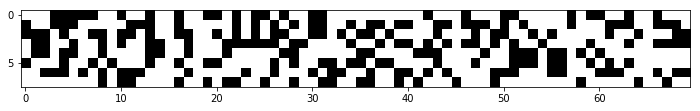

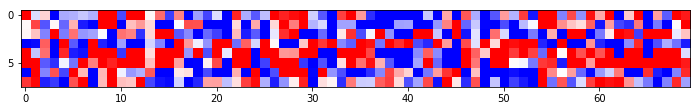

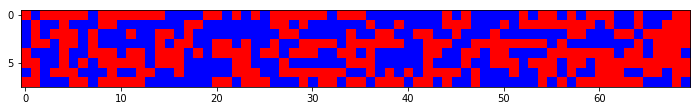

In [31]:
testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))

plt.figure(figsize=(12,3)) 
plt.imshow(y_which_missing[:,num_traits:], cmap='binary', vmin=0, vmax=1.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(testing_values, cmap='bwr', vmin=-1., vmax=1.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(y_truth_01[:,num_traits:], cmap='bwr', vmin=-1., vmax=1.)
plt.show()


In [32]:
testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))
# testing error
total = torch.sum(y_which_missing[:,num_traits:])
count = torch.sum(y_which_missing[:,num_traits:]*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
print('testing acc',count/total)
# training error
total = torch.sum(y_which_missing[:,num_traits:]-1)
count = torch.sum((y_which_missing[:,num_traits:]-1)*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
print('training acc',count/total)


testing acc tensor(0.5247)
training acc tensor(0.9941)


The training accuracy is good, but the testing accuracy is random %50. We think this is because this fake data has no meaning. This system can only guess movies people like by grouping people together based on their preferences. Since this data is random there are no preferences.

# Test on Real Data

Next we imported the real data used in chapter 5 and test our model.

In [34]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [36]:
"""
loading and processing real data
the matrix is 610 by 9724.
"""

ratings = pd.read_csv('ratings.csv')
person_index = list(ratings['userId'].value_counts().keys())
movie_index = list(ratings['movieId'].value_counts().keys())

num_of_users = len(person_index)
num_of_movies = len(movie_index)

ratings = ratings.values[:,:3]

mat  = -1.0* np.ones((num_of_users, num_of_movies), dtype=int)
for idx, rate in enumerate(ratings):
    if(idx%1000 == 0):
        print(".", end='')
    row = person_index.index(rate[0])
    col = movie_index.index(rate[1])
    if rate[2] > 3:  
        mat[row][col] = 1.
    else:
        mat[row][col] = 0.

data = torch.tensor(mat).float()
torch.save(data, 'data.pt')

# data_truth = torch.load('data.pt').float()

.....................................................................................................

In [37]:
# adding self-made mask
num_people = 8
num_movies = 100
data = data_truth[:num_people,:num_movies].clone()
data_real_missing = torch.zeros_like(data_truth[:num_people,:num_movies])
data_real_missing[data_truth[:num_people,:num_movies]==-1]=1.

for i in range(num_people):
    missing_index = np.random.choice(np.arange(0,num_movies), replace=False, size=np.random.randint(low=15, high=25))
    for index in missing_index:
        data[i, index] = -1.

data_which_missing = torch.zeros_like(data)
data_which_missing[data==-1] = 1.

data_truth_01 = data_truth[:num_people,:num_movies].clone()
data_truth_01[data_truth[:num_people,:num_movies]==0] = -1
data_truth_01[data_truth[:num_people,:num_movies]==-1] = -2



....................................................................................................

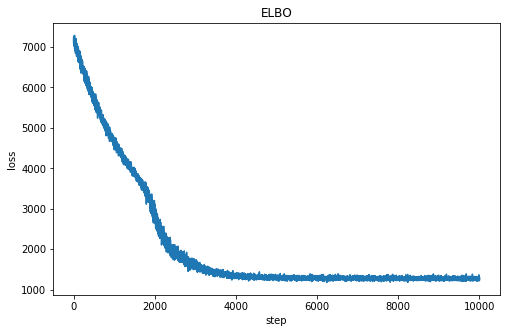

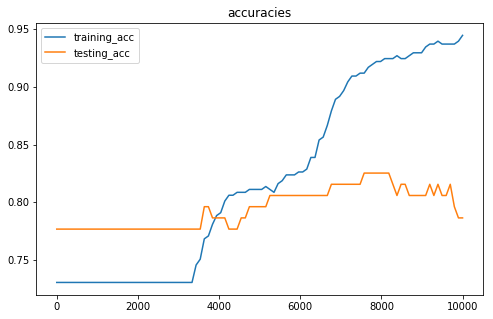

In [38]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_with_mask,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": 0.0008, "betas": (0.90, 0.999)}),
#                      optim=pyro.optim.SGD({"lr": 0.0001, "momentum":0.0003}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
training_acc = []
testing_acc = []
num_steps = 10000
num_traits = 30
for i in range(num_steps):
    losses.append(svi.step(data, num_traits))
    if(i%100==0):
        testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
        total = torch.sum(data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:])
        count = torch.sum((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float()*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        testing_acc.append(count/total)
        total = torch.sum(data_which_missing[:,num_traits:]-1)
        count = torch.sum((data_which_missing[:,num_traits:]-1)*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        training_acc.append(count/total)
        print(".", end='')
        
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(8,5))    
plt.plot(np.linspace(0,num_steps,len(training_acc)), training_acc, label='training_acc')
plt.plot(np.linspace(0,num_steps,len(testing_acc)), testing_acc, label='testing_acc')
plt.title("accuracies")
plt.legend()
plt.show()

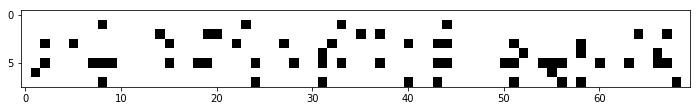

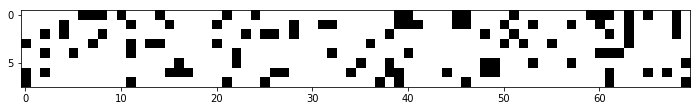

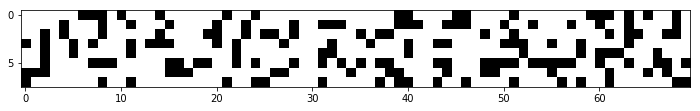

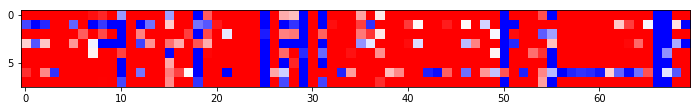

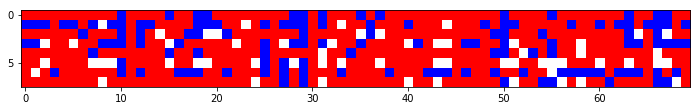

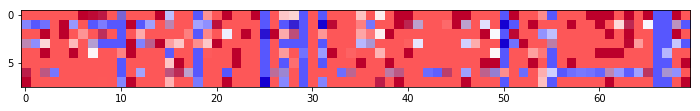

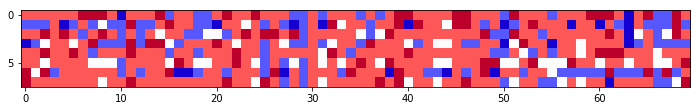

In [39]:
testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))

plt.figure(figsize=(12,3)) 
plt.imshow(data_real_missing[:,num_traits:], cmap='binary', vmin=0, vmax=1.)
plt.show()


plt.figure(figsize=(12,3)) 
plt.imshow((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float(), cmap='binary', vmin=0, vmax=1.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(data_which_missing[:,num_traits:], cmap='binary', vmin=0, vmax=1.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(testing_values, cmap='bwr', vmin=-1., vmax=1.)
plt.show()

data_truth_02 = data_truth[:num_people,:num_movies].clone()
data_truth_02[data_truth[:num_people,:num_movies]==0] = -1
data_truth_02[data_truth[:num_people,:num_movies]==-1] = 0

plt.figure(figsize=(12,3)) 
plt.imshow(data_truth_02[:num_people,:num_movies][:,num_traits:], cmap='bwr', vmin=-1., vmax=1.)
plt.show()

# I cover the second image onto 4th and 5th, 
# so that if the pixel is shaded, it means it comes from testing set
plt.figure(figsize=(12,3)) 
plt.imshow(testing_values, cmap='bwr', vmin=-1., vmax=1.)
plt.imshow((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float(), cmap='Purples', alpha = 0.35, vmin=0, vmax=1.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(data_truth_02[:num_people,:num_movies][:,num_traits:], cmap='bwr', vmin=-1., vmax=1.)
plt.imshow((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float(), cmap='Purples', alpha = 0.35, vmin=0, vmax=1.)
plt.show()


In [40]:
confusion_train = np.zeros((2,2))
confusion_test = np.zeros((2,2))
for i in range(num_people):
    for j in range(num_movies-num_traits):
        if data_real_missing[i,j+num_traits] != 1:
            if data_which_missing[i,j+num_traits]!=data_real_missing[i,j+num_traits]: # testing set
                if data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_test[0,0] = confusion_test[0,0] + 1
                elif data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_test[1,0] = confusion_test[1,0] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_test[0,1] = confusion_test[0,1] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_test[1,1] = confusion_test[1,1] + 1
            else: # training set
                if data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_train[0,0] = confusion_train[0,0] + 1
                elif data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_train[1,0] = confusion_train[1,0] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_train[0,1] = confusion_train[0,1] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_train[1,1] = confusion_train[1,1] + 1


In [41]:
print('confusion matrix of training set\n',confusion_train)
print('confusion matrix of testing set\n',confusion_test)

confusion matrix of training set
 [[284.  17.]
 [  6.  90.]]
confusion matrix of testing set
 [[75. 16.]
 [ 5.  7.]]


In [42]:
testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
total = torch.sum(data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:])
count = torch.sum((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float()*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
print('testing acc', count/total)
total = torch.sum(data_which_missing[:,num_traits:]-1)
count = torch.sum((data_which_missing[:,num_traits:]-1)*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
training_acc.append(count/total)
print('training acc',count/total)


testing acc tensor(0.7961)
training acc tensor(0.9421)


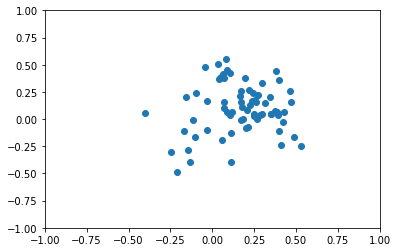

In [43]:
plt.scatter(pyro.param("mean_trait").data[:,0],pyro.param("mean_trait").data[:,1])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_points = pca.fit_transform(pyro.param("mean_trait").data)
print(pca.singular_values_)

[7.26345297 5.05047072 4.10523382 3.0031916  2.43628734]


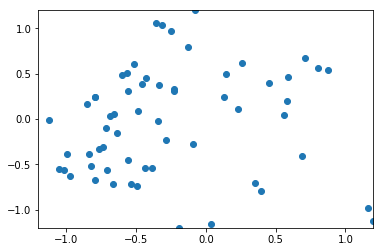

In [45]:
plt.scatter(pca_points[:,0],pca_points[:,1])
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.show()

# Adding Stars

Our model works in a binary context of like or dislike the movie. The actual information the rating system is based on is 5 stars. Instead of testing whether or not somelike likes or dislikes the movie we can test to see if they rated it a certain star value. We can repeat this 9 times (the starts go by .5 from 0.5 to 5).

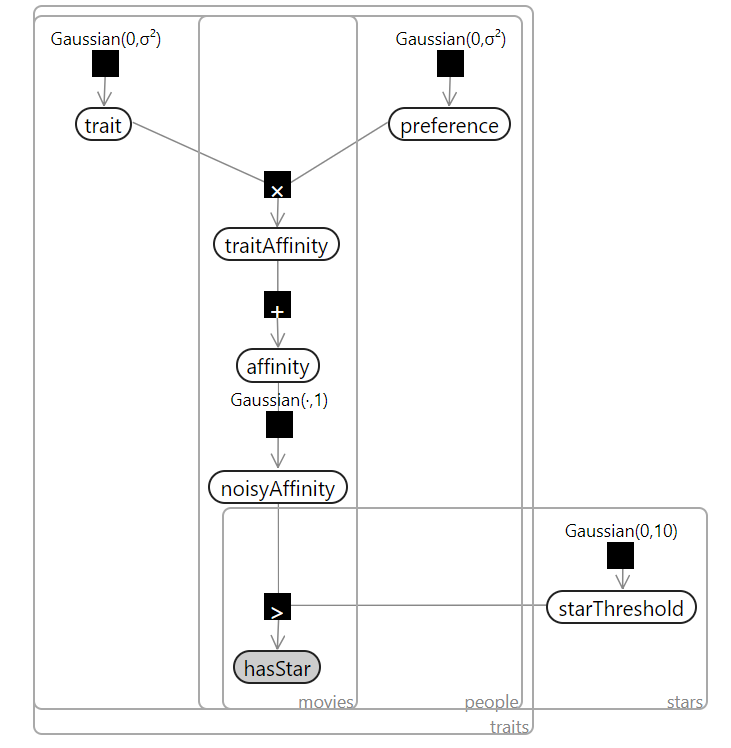

In [46]:
display(Image(filename="factorgraph4.png"))

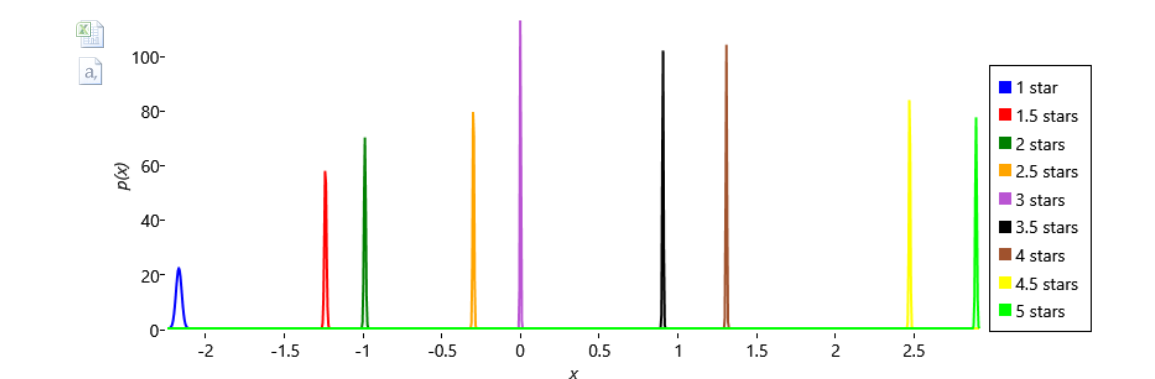

In [47]:
display(Image(filename="starts.png"))

In [48]:
ratings = pd.read_csv('ratings.csv')
set(ratings['rating'])


{0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}

In [49]:
person_index = list(ratings['userId'].value_counts().keys())
movie_index = list(ratings['movieId'].value_counts().keys())

num_of_users = len(person_index)
num_of_movies = len(movie_index)

ratings = ratings.values[:,:3]

mat  = np.zeros((num_of_users, num_of_movies))
for idx, rate in enumerate(ratings):
    if(idx%1000 == 0):
        print(".", end='')
    row = person_index.index(rate[0])
    col = movie_index.index(rate[1])
    mat[row][col] = rate[2]

data_truth = torch.tensor(mat)
torch.save(data_truth, 'data_ratings.pt')
# data_truth = torch.load('data_ratings.pt').float()


.....................................................................................................

In [50]:
data_truth[:10,:10].float()

tensor([[5.0000, 5.0000, 5.0000, 4.0000, 5.0000, 5.0000, 4.0000, 5.0000, 5.0000,
         4.0000],
        [3.5000, 4.0000, 5.0000, 3.0000, 5.0000, 5.0000, 4.0000, 3.5000, 4.5000,
         0.0000],
        [3.0000, 5.0000, 4.0000, 4.5000, 4.5000, 4.0000, 4.5000, 3.0000, 4.0000,
         5.0000],
        [3.0000, 0.0000, 5.0000, 5.0000, 2.0000, 5.0000, 3.0000, 0.0000, 3.0000,
         0.0000],
        [4.5000, 4.5000, 5.0000, 4.0000, 4.0000, 3.0000, 3.5000, 4.5000, 4.5000,
         4.0000],
        [3.0000, 3.0000, 5.0000, 4.5000, 5.0000, 5.0000, 5.0000, 4.5000, 5.0000,
         3.5000],
        [3.5000, 3.0000, 2.0000, 3.5000, 4.5000, 5.0000, 3.5000, 2.5000, 3.5000,
         4.0000],
        [5.0000, 3.0000, 5.0000, 5.0000, 4.5000, 5.0000, 5.0000, 4.0000, 5.0000,
         0.0000],
        [4.0000, 3.5000, 5.0000, 4.5000, 5.0000, 4.5000, 2.5000, 3.5000, 3.5000,
         5.0000],
        [5.0000, 5.0000, 5.0000, 5.0000, 3.0000, 5.0000, 2.0000, 5.0000, 4.0000,
         5.0000]])

In [51]:
# adding self-made mask
num_people = 8
num_movies = 100
data = data_truth[:num_people,:num_movies].clone()
data_real_missing = torch.zeros_like(data_truth[:num_people,:num_movies])
data_real_missing[data_truth[:num_people,:num_movies]==0]=1.

for i in range(num_people):
    missing_index = np.random.choice(np.arange(0,num_movies), replace=False, size=np.random.randint(low=15, high=25))
    for index in missing_index:
        data[i, index] = 0.

data_which_missing = torch.zeros_like(data)
data_which_missing[data==0] = 1.

# data_truth_01 = data_truth[:num_people,:num_movies].clone()
# data_truth_01[data_truth[:num_people,:num_movies]==0] = -1
# data_truth_01[data_truth[:num_people,:num_movies]==-1] = -2


In [52]:
def model_with_star(y, num_traits):
    num_people, num_movies = y.shape
    mean_pref = torch.tensor(0.)
    std_pref = torch.tensor(1.)
    mean_trait = torch.tensor(0.)
    std_trait = torch.tensor(1.)
    mean_threshold = torch.tensor(0.)
    std_threshold = torch.tensor(1.)
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
    with pyro.plate("stars", 8):
        threshold = pyro.sample("threshold",dist.Normal(mean_threshold, std_threshold))
    threshold_3star = pyro.sample("threshold_3star", dist.Normal(mean_threshold, std_threshold), obs = torch.tensor(0.))
    
    known_trait = pyro.sample("known_trait", dist.Normal(mean_trait, std_trait), obs = torch.eye(num_traits))
    known_affinity = torch.mm(pref, known_trait.transpose(0,1))
    known_noisy_affinity = pyro.sample('known_noisy_affinity', dist.Normal(known_affinity,torch.tensor(0.2)))
    
    a = torch.zeros_like(known_noisy_affinity)
    for i in torch.cat((threshold[:4], threshold_3star.reshape((1,)),threshold[4:]),0):
        a = a + 0.5*(known_noisy_affinity > i).float()
    is_observed = (y[:,:num_traits] != 0)
    with pyro.poutine.mask(mask=is_observed):
        known_has_star = pyro.sample('known_has_star',dist.Bernoulli(torch.sigmoid(a)), obs=y[:,:num_traits])
    
    affinity = torch.mm(pref, trait.transpose(0,1))
    noisy_affinity = pyro.sample('noisy_affinity', dist.Normal(affinity, torch.tensor(0.2)))
    
    a = torch.zeros_like(noisy_affinity)+0.5
    for i in torch.cat((threshold[:4], threshold_3star.reshape((1,)),threshold[4:]),0):
        a = a + 0.5*(noisy_affinity > i).float()
    is_observed = (y[:,num_traits:] != 0)
    with pyro.poutine.mask(mask=is_observed):
        has_star = pyro.sample('has_star',dist.Bernoulli(torch.sigmoid(a)), obs=y[:,num_traits:])
    
def guide(y, num_traits):
    num_people, num_movies = y.shape
    
    mean_pref = pyro.param("mean_pref", torch.zeros(num_people, num_traits)+2)
    std_pref = pyro.param("std_pref", torch.ones(num_people, num_traits))
    mean_trait = pyro.param("mean_trait", torch.zeros(num_movies-num_traits,num_traits)+2)
    std_trait = pyro.param("std_trait", torch.ones(num_movies-num_traits,num_traits))
    mean_threshold = pyro.param("mean_threshold", torch.arange(-4,5,1).float())
    mean_threshold = torch.cat([mean_threshold[0:4], mean_threshold[5:]])
    std_threshold = pyro.param("std_threshold", torch.ones(8)*5)
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
    with pyro.plate("stars", 8):
        threshold = pyro.sample("threshold",dist.Normal(mean_threshold, std_threshold))


....................................................................................................

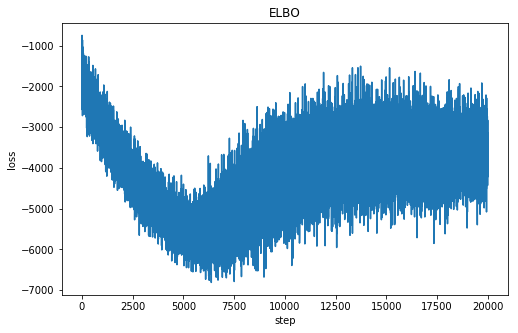

In [53]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_with_star,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": 0.0003, "betas": (0.90, 0.999)}),
#                      optim=pyro.optim.SGD({"lr": 0.0002, "momentum":0.0003}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
training_acc = []
testing_acc = []
num_steps = 20000
num_traits = 30
for i in range(num_steps):
    losses.append(svi.step(data.float(), num_traits))
    if(i%200==0):
#         testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
#         total = torch.sum(data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:])
#         count = torch.sum((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float()*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
#         testing_acc.append(count/total)
#         total = torch.sum(data_which_missing[:,num_traits:]-1)
#         count = torch.sum((data_which_missing[:,num_traits:]-1)*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
#         training_acc.append(count/total)
        print(".", end='')
        
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()


In [54]:
pyro.param("mean_threshold").data

tensor([-0.9717, -0.6074, -0.3670, -0.1941,  0.0000,  0.1530,  0.3591,  0.5920,
         0.9558])

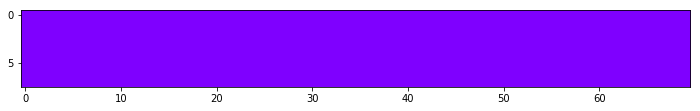

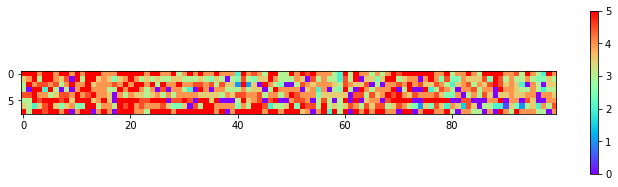

In [55]:
testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))

plt.figure(figsize=(12,3)) 
plt.imshow(testing_values, cmap='rainbow', vmin=0., vmax=5.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(data_truth[:8,:100], cmap='rainbow', vmin=0., vmax=5.)
plt.colorbar()
plt.show()
